In [44]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Load dữ liệu (Hãy đảm bảo đường dẫn file đúng)
file_path = 'VN_BĐS_data/property_cleaned.csv' 
df = pd.read_csv(file_path, low_memory=False)

print(f"Kích thước dữ liệu gốc: {df.shape}")
df.head(5)

Kích thước dữ liệu gốc: (76837, 12)


,Diện tích,Phòng ngủ,Số tầng,Số toilet,Số phòng khách,Loại địa ốc,Địa chỉ,Pháp lý,Hướng nhà,Đường trước nhà,Giá nhà,tag
0,77m2,NaN,NaN,NaN,NaN,Bán nhà riêng,NaN,NaN,NaN,NaN,15 tỷ,da_nang
1,205m2,5 PN,2 tầng,3.0,1.0,Bán nhà riêng,NaN,Sổ hồng,Tây,10m - 15m,11 tỷ 500 triệu,da_nang
2,96m2,NaN,NaN,NaN,NaN,Bán nhà riêng,NaN,NaN,NaN,NaN,4 tỷ 750 triệu,da_nang
3,92m2,NaN,NaN,NaN,NaN,Bán căn hộ chung cư,NaN,NaN,NaN,NaN,1 tỷ 400 triệu,da_nang
4,105m2,NaN,NaN,NaN,NaN,Bán căn hộ chung cư,NaN,NaN,NaN,NaN,49 triệu,da_nang


In [45]:
def clean_area(x):
    """Chuyển '77m2' -> 77.0"""
    if pd.isna(x): return np.nan
    x = str(x).lower().replace('m2', '').replace(',', '.').strip()
    try:
        val = float(x)
        return val if val > 0 else np.nan
    except: return np.nan

def extract_number(x):
    """Lấy số đầu tiên trong chuỗi (dùng cho Phòng/Tầng)"""
    if pd.isna(x): return np.nan # Để NaN để xử lý sau (không điền 0 vội)
    match = re.search(r'(\d+(\.\d+)?)', str(x))
    return float(match.group(1)) if match else np.nan

def clean_road(x):
    """Xử lý đường: '10m' -> 10.0, '10m-12m' -> 11.0"""
    if pd.isna(x): return np.nan
    x = str(x).lower().replace('m', '').strip()
    try:
        if '-' in x:
            parts = x.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        return float(x)
    except: return np.nan

def clean_price_final(row):
    """Xử lý giá: Tách tỷ/triệu, xử lý giá/m2, trả về đơn vị TRIỆU VNĐ"""
    price_str = str(row['Giá nhà']).lower()
    area = row['cleaned_area'] # Cần tính diện tích trước
    
    if pd.isna(price_str) or pd.isna(area) or area == 0: return np.nan
    
    # Chuẩn hóa
    s = price_str.replace('/m2', '').replace(',', '.')
    
    # Tách số
    billion, million = 0, 0
    try:
        if 'tỷ' in s: 
            billion = float(re.search(r'([\d\.]+)\s*tỷ', s).group(1))
        if 'triệu' in s: 
            million = float(re.search(r'([\d\.]+)\s*triệu', s).group(1))
    except: pass
    
    # Tổng giá trị (đơn vị Triệu)
    val_million = (billion * 1000) + million
    
    if val_million == 0: return np.nan
    
    # Nếu là giá /m2 HOẶC giá quá nhỏ (< 100 triệu) -> Nhân với diện tích
    if '/m2' in price_str or val_million < 100:
        val_million = val_million * area
        
    return val_million

# --- ÁP DỤNG LÀM SẠCH ---
# 1. Diện tích (Làm trước để tính giá)
df['cleaned_area'] = df['Diện tích'].apply(clean_area)

# 2. Giá (Đơn vị: Triệu VNĐ)
df['cleaned_price'] = df.apply(clean_price_final, axis=1)

# 3. Các cột số khác
df['cleaned_road'] = df['Đường trước nhà'].apply(clean_road)
df['bed'] = df['Phòng ngủ'].apply(extract_number)
df['bath'] = df['Số toilet'].apply(extract_number)
df['floor'] = df['Số tầng'].apply(extract_number)

# 4. Xóa các dòng không có Giá hoặc Diện tích (Dữ liệu chết)
df_clean = df.dropna(subset=['cleaned_price', 'cleaned_area']).copy()
print(f"Kích thước sau khi parse: {df_clean.shape}")

Kích thước sau khi parse: (76587, 18)


In [46]:
# 1. Xác định loại bất động sản (Đất vs Nhà)
df_clean['Loại địa ốc'] = df_clean['Loại địa ốc'].astype(str).str.lower()
df_clean['is_land'] = df_clean['Loại địa ốc'].apply(lambda x: 1 if 'đất' in x else 0)

# 2. Điền dữ liệu thiếu (Logic thông minh)
# - Nếu là Đất (is_land=1) -> Phòng/Toilet/Tầng = 0
# - Nếu là Nhà (is_land=0) -> Điền Median của nhóm Nhà

cols_metric = ['bed', 'bath', 'floor']
for col in cols_metric:
    # Với Đất: Điền 0
    df_clean.loc[df_clean['is_land'] == 1, col] = df_clean.loc[df_clean['is_land'] == 1, col].fillna(0)
    
    # Với Nhà: Điền Median (ví dụ: 2 phòng ngủ, 2 toilet)
    median_val = df_clean.loc[df_clean['is_land'] == 0, col].median()
    df_clean.loc[df_clean['is_land'] == 0, col] = df_clean.loc[df_clean['is_land'] == 0, col].fillna(median_val)

# Điền đường trước nhà bằng Median chung
df_clean['cleaned_road'] = df_clean['cleaned_road'].fillna(df_clean['cleaned_road'].median())

# 3. Thêm cột Đơn giá/m2 (Feature cực mạnh để lọc nhiễu)
df_clean['price_per_m2'] = df_clean['cleaned_price'] / df_clean['cleaned_area']

print("Mẫu dữ liệu sau khi điền khuyết:")
display(df_clean[['Loại địa ốc', 'cleaned_area', 'cleaned_price', 'bed', 'is_land']].head())

Mẫu dữ liệu sau khi điền khuyết:


,Loại địa ốc,cleaned_area,cleaned_price,bed,is_land
0,bán nhà riêng,77.0,15000.0,3.0,0
1,bán nhà riêng,205.0,11500.0,5.0,0
2,bán nhà riêng,96.0,4750.0,3.0,0
3,bán căn hộ chung cư,92.0,1400.0,3.0,0
4,bán căn hộ chung cư,105.0,5145.0,3.0,0


In [ ]:
# 1. Lọc theo Diện tích
# Bỏ nhà < 10m2 (quá nhỏ/lỗi) và > 1000m2 (thường là đất dự án/lỗi nhập liệu)
df_final = df_clean[(df_clean['cleaned_area'] >= 10) & (df_clean['cleaned_area'] <= 1000)]

# 2. Lọc theo Đơn giá/m2
# Loại bỏ giá < 2 triệu/m2 (quá rẻ) và > 500 triệu/m2 (quá đắt)
df_final = df_final[(df_final['price_per_m2'] >= 2) & (df_final['price_per_m2'] <= 500)]

# 3. Lọc theo Tổng giá
# Bỏ nhà < 100 triệu (lỗi) hoặc > 100 Tỷ (quá hiếm, gây nhiễu)
df_final = df_final[(df_final['cleaned_price'] >= 100) & (df_final['cleaned_price'] <= 100000)]

# 4. Lọc Outlier bằng phương pháp Percentile (Thống kê)
# Loại bỏ 1% giá trị nhỏ nhất và 1% giá trị lớn nhất còn lại để cắt đuôi phân phối (tránh nhiễu cực đoan)
def remove_outliers_percentile(df, col, lower=0.01, upper=0.99):
    low_val = df[col].quantile(lower)
    high_val = df[col].quantile(upper)
    print(f"Lọc {col}: giữ lại từ {low_val:.2f} đến {high_val:.2f}")
    return df[(df[col] >= low_val) & (df[col] <= high_val)]

df_final = remove_outliers_percentile(df_final, 'cleaned_price')
df_final = remove_outliers_percentile(df_final, 'cleaned_area')

print(f"Dữ liệu sạch cuối cùng: {df_final.shape}")
print(f"Đã loại bỏ tổng cộng {df.shape[0] - df_final.shape[0]} dòng dữ liệu rác/ngoại lai.")

Lọc cleaned_price: giữ lại từ 300.00 đến 34000.00
Lọc cleaned_area: giữ lại từ 32.00 đến 696.00
Dữ liệu sạch cuối cùng: (66926, 20)
Đã loại bỏ tổng cộng 9911 dòng dữ liệu rác/ngoại lai.


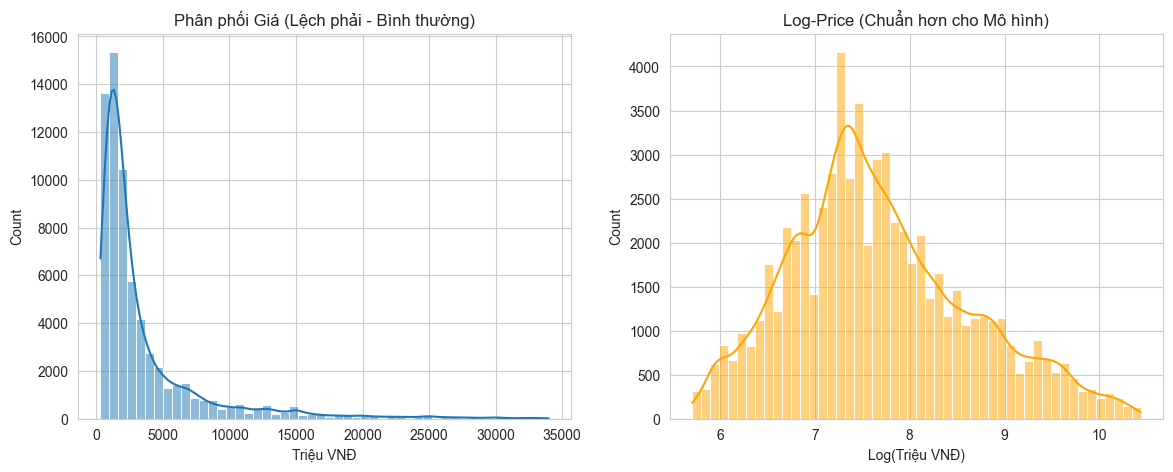

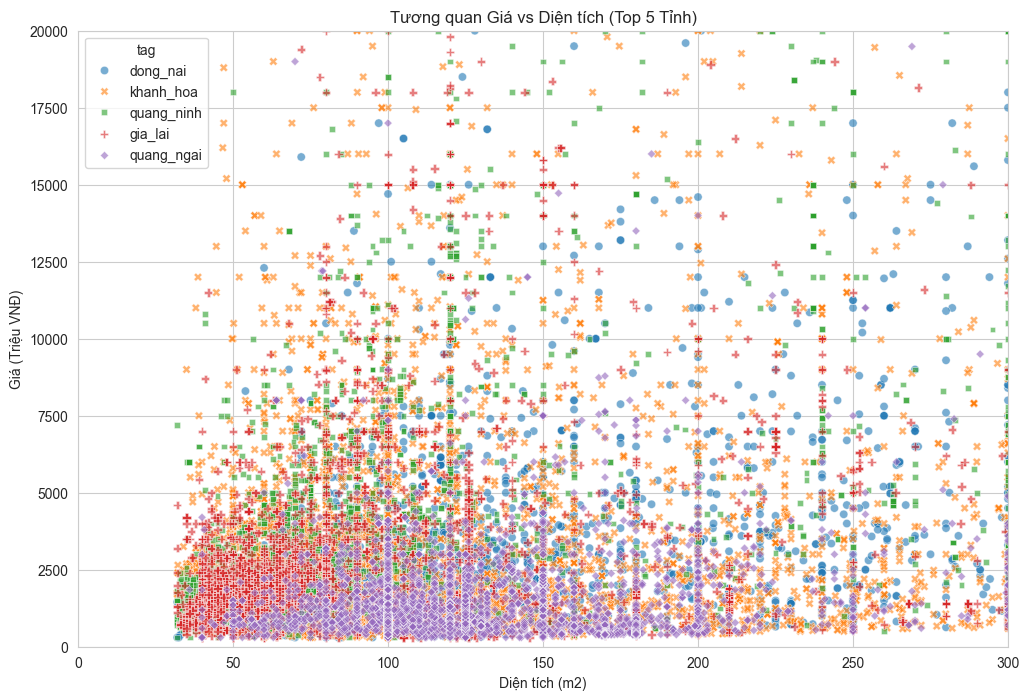

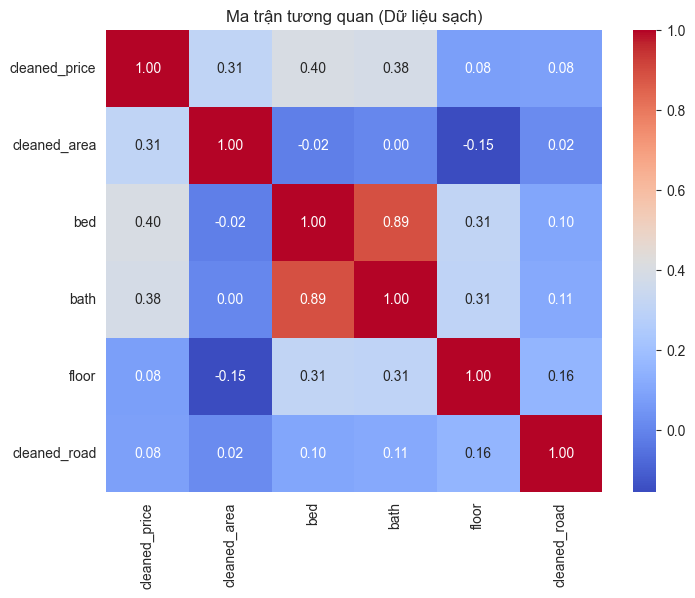

In [ ]:
# 1. Phân phối Giá nhà
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_final['cleaned_price'], bins=50, kde=True)
plt.title('Phân phối Giá (Lệch phải - Bình thường)')
plt.xlabel('Triệu VNĐ')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_final['cleaned_price']), bins=50, kde=True, color='orange')
plt.title('Log-Price (Chuẩn hơn cho Mô hình)')
plt.xlabel('Log(Triệu VNĐ)')
plt.show()

# 2. Tương quan Giá vs Diện tích (Phân tách theo Tỉnh)
# Lấy top 5 tỉnh
top_tags = df_final['tag'].value_counts().head(5).index
df_plot = df_final[df_final['tag'].isin(top_tags)]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot, 
    x='cleaned_area', 
    y='cleaned_price', 
    hue='tag', 
    alpha=0.6, 
    style='tag'
)
plt.title('Tương quan Giá vs Diện tích (Top 5 Tỉnh)')
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá (Triệu VNĐ)')
plt.xlim(0, 300) 
plt.ylim(0, 20000) # < 20 Tỷ
plt.show()

# 3. Ma trận tương quan
corr_cols = ['cleaned_price', 'cleaned_area', 'bed', 'bath', 'floor', 'cleaned_road']
plt.figure(figsize=(8, 6))
sns.heatmap(df_final[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan (Dữ liệu sạch)')
plt.show()

In [49]:
# Chọn các cột cần thiết cho model
final_columns = [
    'cleaned_area', 'cleaned_road', 'bed', 'bath', 'floor', 
    'is_land', 'tag', 'Loại địa ốc', 'Pháp lý', 'cleaned_price'
]

df_export = df_final[final_columns]
df_export.to_csv('VN_BĐS_data/property_final_clean.csv', index=False)
print("Đã lưu file: VN_BĐS_data/property_final_clean.csv")

Đã lưu file: VN_BĐS_data/property_final_clean.csv
